# San Francisco Neighborhood Analysis

### _Notes_
_This project is a part of the ["Capstone Project" of Coursera - "IBM Applied Data Science Capstone Course"](https://www.coursera.org/professional-certificates/ibm-data-science)._

_Unfortunately, GitHub does not display maps correctly. To view them, clone my repository and run it locally. You need to have your Foursquare ID, Foursquare Secret and your key for Geocoding API._

## Introduction

San Francisco is a very vibrant city with a lot of neighborhoods, each with own character. Some neighborhoods are are quite and cozy, has a convientent store locations, while others offer a lot of fun and night life activities. Choosing neiborhood to live or open a bussiness can be a complicated task to do, but with a help of Foursquare and crime data we can make it a little bit easier.

### Target Audience

1. People interested in moving to San Francisco and looking for a perferct neighbourhood for their needs
2. Bussiness owners looking to expand thier bussiness to a new location
3. Beginner data scientiest who may use this research as an example

## Data Preparation

For this project we will pull the data from a multiple sources:
1. [Wikipedia](https://wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco) - list of SF neighbourhoods
2. [Google Geocoding](https://developers.google.com/maps/documentation/geocoding/intro) - geocoordinates of neighbourhoods
3. [Kaggle SF Police Incidents Dataset 2018-2019](https://www.kaggle.com/psmavi104/san-francisco-crime-data) - crime data
3. [Foursquare](https://foursquare.com/) - venues data for closest stores, parks and attractions for each neighbourhood

In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import json  
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

!conda install -c conda-forge folium=0.10.1 --yes 
#uncomment if you need to install folium
import folium #maps library

from sklearn.cluster import KMeans

Solving environment: ...working... done

# All requested packages already installed.



### Neighbourhoods Data

First, we need to get a full list of the all SF neighborhoods. Wikipedia article [list of neighborhoods in San Francisco](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco "wikipedia.org") is a great place to start. Can you guess how many of them are in SF? 119!

In [2]:
link = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco")
soup = BeautifulSoup(link.text, "lxml")

neighborhoods_list = []
ignore = [
    'See also',
    'References',
    'External links',
    'Specific neighborhoods',
]
for article in soup.find_all(class_="mw-headline"):
    if not article.string in ignore:
        neighborhoods_list.append(article.string)

We will use Geocoding API to get geolocation information. To get more information about how to use Geocoding API, follow [Geocoding Developer Guide](https://developers.google.com/maps/documentation/geocoding/intro "Geocoding API Guide").

In [5]:
#private information deleted
KEY = #key for Geocoding API

In [6]:
def get_json_neig_data(neighborhoods_list):
    try:
        with open("sf_geocoding.json") as data:
            json_list = json.load(data)
    except IOError:
        json_list = []
        for neighborhood in neighborhoods_list:
            parameters = {
                "address": "%s, San Francisco, CA" % neighborhood,
                "key": KEY 
            }
            results = requests.get(
                'https://maps.googleapis.com/maps/api/geocode/json', 
                params=parameters
            ).json()
            json_list.append(results)
        with open("sf_geocoding.json", 'w') as outfile:
            json.dump(json_list, outfile)
        
    return json_list

In [7]:
neig_lat_lng_list = []

for element in get_json_neig_data(neighborhoods_list):
    if element['results']:
        neig_lat_lng_list.append([
            element['results'][0]['address_components'][0]['long_name'],
            element['results'][0]['geometry']['location']['lat'],
            element['results'][0]['geometry']['location']['lng']
        ])
    

We manually fix some neighbourhood names which appear to be incorrect in Geocoding output.

In [8]:
sf_df = pd.DataFrame(
    data=neig_lat_lng_list,
    columns=["Neighborhood", "Latitude", "Longitude"],
)

#correct mistakes
sf_df.loc[118, "Neighborhood"] = "Butchertown"
sf_df.loc[98, "Neighborhood"] = "South End"
sf_df.loc[99, "Neighborhood"] = "South of Market"
sf_df.loc[68, "Neighborhood"] = "Mission"

sf_df.head(10)

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.777499,-122.433252
1,Anza Vista,37.780868,-122.443185
2,Ashbury Heights,37.765327,-122.445308
3,Balboa Park,37.724569,-122.443357
4,Balboa Terrace,37.731333,-122.468661
5,Bayview,37.730416,-122.384424
6,Belden Place,37.791249,-122.403697
7,Bernal Heights,37.738950,-122.415201
8,Buena Vista,37.765600,-122.442166
9,5273,37.729503,-122.392329


To plot data on the map we need to convert geocoordinate values from string to float.

In [9]:
sf_df.astype({'Latitude' : 'float64', 'Longitude' : 'float64'}).dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [10]:
address = 'San Francisco'

geolocator = Nominatim(user_agent = "san_francisco_explorer")
sf_location = geolocator.geocode(address)
sf_latitude = sf_location.latitude
sf_longitude = sf_location.longitude

print('The geograpical coordinates of San Francisco are {}, {}.'.format(sf_latitude, sf_longitude))

The geograpical coordinates of San Francisco are 37.7647993, -122.4629897.


Plor neighbourhood markers on the map: 

In [11]:
sf_map = folium.Map(
    location=[sf_latitude, sf_longitude], 
    tiles='Stamen Toner', 
    zoom_start=12.5, 
)

# add markers to map
for lat, lng, neighborhood in zip(sf_df['Latitude'], sf_df['Longitude'], sf_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [lat, lng],
        popup = label,
    ).add_to(sf_map)
sf_map

### 2. Criminal Data

To analise criminal activity for each neighbourhood we use [Police Department Incident Reports: 2018 to Present](https://www.kaggle.com/psmavi104/san-francisco-crime-data "kaggle.com") dataset from Kaggle. It containes information about location, time, category and other miscellaneous data from SF Police Department.

In [12]:
crime_df = pd.read_csv("SF_Police_Department_Incident_Reports__2018_to_Present.csv")

In [13]:
crime_df.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites)
0,2018/07/18 01:30:00 PM,2018/07/18,13:30,2018,Wednesday,2018/07/18 01:31:00 PM,69250964070,692509,180536729,182001522.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019/04/08 05:25:00 AM,2019/04/08,05:25,2019,Monday,2019/04/13 01:34:00 PM,79165671000,791656,196076240,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019/06/05 02:00:00 PM,2019/06/05,14:00,2019,Wednesday,2019/06/05 02:30:00 PM,81006072000,810060,190416337,191610728.0,...,-122.422464,"(37.78268536745206, -122.42246374465972)",100.0,4.0,11.0,39.0,NaN,NaN,NaN,NaN
3,2019/04/16 08:20:00 PM,2019/04/16,20:20,2019,Tuesday,2019/04/17 12:21:00 AM,79171306244,791713,196076024,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019/06/10 11:00:00 AM,2019/06/10,11:00,2019,Monday,2019/06/10 11:00:00 AM,81012372000,810123,190393440,191521989.0,...,-122.464145,"(37.779090726308574, -122.46414497098554)",5.0,8.0,4.0,11.0,NaN,NaN,NaN,NaN


We filter data to exclude certain crime categories, such as traffic collision and suspicious acitvity that doesn't releated to quality of life in the neighbourhood. Also we delete miscellaneous data about incedents, that doesn't play role in our analysis.

In [14]:
for category in ['Suspicious Occ', 'Non-Criminal', 'Traffic Collision', 'Suicide', 'Suspicious']:
    crime_df.drop(
        crime_df[crime_df['Incident Category'] == category].index , 
        inplace=True
    )

In [15]:
crime_df.drop(
    columns=[
        "Incident Datetime",
        "Incident Date",
        "Incident Time",
        "Incident Year",
        "Incident Day of Week",
        "Report Datetime",
        "Row ID",
        "Incident Number",
        "CAD Number",
        "point",
        "SF Find Neighborhoods",
        "Current Police Districts",
        "Current Supervisor Districts",
        "Analysis Neighborhoods",
        "HSOC Zones as of 2018-06-05",
        "OWED Public Spaces",
        "Central Market/Tenderloin Boundary Polygon - Updated",
        "Parks Alliance CPSI (27+TL sites)",
        "Supervisor District",
        "CNN",
        "Intersection",
        "Resolution",
        "Incident Description",
        "Report Type Code",
        "Report Type Description",
        "Filed Online",
        "Incident Code",
        "Incident Category",
        "Incident Subcategory",
        "Incident Description",
        "Police District",
        "Latitude",
        "Longitude"
    ],
    inplace=True
)
crime_df.dropna(inplace=True)
crime_df.rename(columns={"Analysis Neighborhood": "Neighborhood"}, inplace=True)
crime_df.head()

,Incident ID,Neighborhood
5,810219,Tenderloin
7,809979,Outer Mission
8,810263,Financial District/South Beach
9,810040,Haight Ashbury
10,810005,Castro/Upper Market


We count number of incidents for each neighbourhood.

In [16]:
crime_count_df = crime_df.groupby('Neighborhood').agg(['count'])
crime_count_df.reset_index(inplace=True)
crime_count_df.columns = crime_count_df.columns.droplevel(level=1)
crime_count_df.rename(columns={"Incident ID": "Number of Crimes"}, inplace=True)
crime_count_df.sort_values(by="Number of Crimes", ascending=False).head(10)

,Neighborhood,Number of Crimes
18,Mission,22850
35,Tenderloin,20130
5,Financial District/South Beach,18907
33,South of Market,17015
0,Bayview Hunters Point,11111
22,North Beach,6501
40,Western Addition,6292
2,Castro/Upper Market,5953
34,Sunset/Parkside,5613
20,Nob Hill,5372


Sometimes police department files multiple slash separated neighborhoods into the same incedent. In this case we split the number of incidents equally between this two areas.

In [17]:
crime_count_df[crime_count_df["Neighborhood"].str.contains('/', regex=False)]

,Neighborhood,Number of Crimes
2,Castro/Upper Market,5953
5,Financial District/South Beach,18907
15,Lone Mountain/USF,2272
23,Oceanview/Merced/Ingleside,2005
34,Sunset/Parkside,5613


In [18]:
df2 = pd.DataFrame(
    {
        'Neighborhood': [
            "The Castro", 
            "Upper Market", 
            "Financial District", 
            "South Beach",                    
            "Lone Mountain", 
            "Oceanview", 
            "Merced", 
            "Ingleside", 
            "Sunset", 
            "Parkside"
        ],
        'Number of Crimes': [
            5953//2,
            5953//2, 
            18907//2, 
            18907//2,
            2272,
            2005//3,
            2005//3,                          
            2005//3, 
            5613//2, 
            5613//2
        ]
})
crime_count_df = crime_count_df.append(df2, ignore_index=True)
crime_count_df.drop(index=[2, 5, 15, 23, 34], inplace=True)

crime_count_df.head(10)

,Neighborhood,Number of Crimes
0,Bayview Hunters Point,11111
1,Bernal Heights,3180
3,Chinatown,3654
4,Excelsior,3127
6,Glen Park,928
7,Golden Gate Park,2013
8,Haight Ashbury,3266
9,Hayes Valley,5092
10,Inner Richmond,2439
11,Inner Sunset,2150


Merge neighbourhood crime data with the list we got from Wikipedia, filtering out areas with no available data.

In [19]:
sf_crime_join_df = sf_df.merge(
    crime_count_df, 
    left_on="Neighborhood", 
    right_on="Neighborhood"
)

sf_crime_join_df.sort_values(by="Number of Crimes", ascending=False).head(10)

,Neighborhood,Latitude,Longitude,Number of Crimes
14,Mission,37.770628,-122.391166,22850
26,Tenderloin,37.784660,-122.414506,20130
25,South of Market,37.807690,-122.421094,17015
4,Financial District,37.794574,-122.399945,9453
5,Financial District,37.794574,-122.399945,9453
17,North Beach,37.806053,-122.410331,6501
31,Western Addition,37.782211,-122.434178,6292
15,Nob Hill,37.793014,-122.416113,5372
7,Hayes Valley,37.775907,-122.424525,5092
24,Russian Hill,37.801060,-122.419449,4582


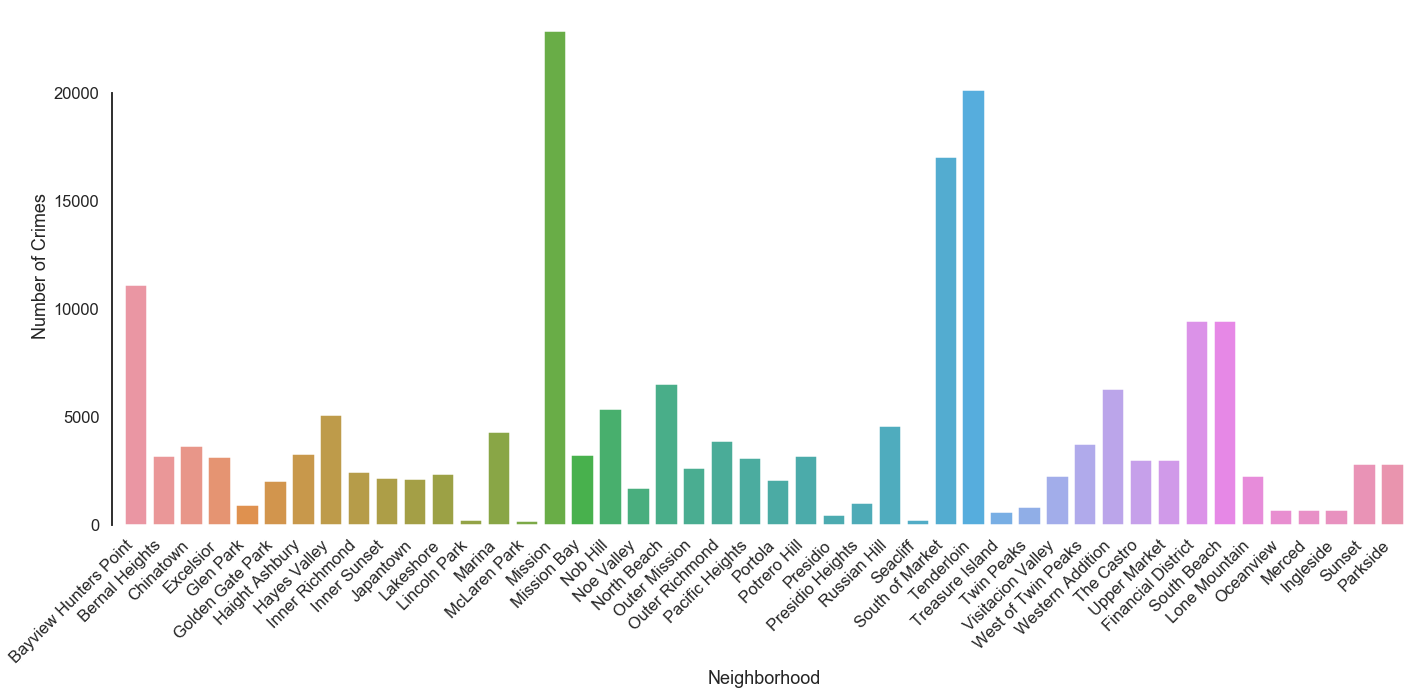

In [20]:
plt.figure(figsize=(20, 10))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=crime_count_df,
    x=crime_count_df["Neighborhood"],
    y=crime_count_df["Number of Crimes"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

### 3. Venues Data (Foursquare API)

Foursquare API provides information about venues and geolocation.

In [22]:
#Define Foursquare Credentials and Version
#Private information deleted
CLIENT_ID = # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# defining radius and limit of venues to get
radius=1000
LIMIT=200

In [23]:
def getVeneus(neighborhood, latitude, longitude, category=None, radius=1000):
    venues_list = []
    params = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "v": VERSION,
        "ll": "{},{}".format(latitude, longitude),
        "radius": radius,
        "limit": LIMIT,
    }
    url = 'https://api.foursquare.com/v2/venues/search'    
    results = requests.get(url, params=params).json()

    if not results["response"]:
        return []

    for v in results["response"]['venues']:
        if not v['categories']:
            continue
        venues_list.append([
            neighborhood,
            latitude, 
            longitude, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]["name"]
        ])
    return venues_list

In [24]:
def getNearbyVenues(neighborhoods, latitudes, longitudes, category=None, radius=1000):
    
    venues_list=[]
    for neig, lat, lng in zip(neighborhoods, latitudes, longitudes):
        results = getVeneus(neig, lat, lng, category=category, radius=radius)
        venues_list += results
        
    if not venues_list:
        print("venue list is empty")
        return []
    
    venues_data = pd.DataFrame(venue for venue in venues_list)
    venues_data.columns = [
        'Neighborhood', 
        'Neighborhood Latitude', 
        'Neighborhood Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude',
        'Venue Category',
    ]
    
    return venues_data

In [25]:
venues_df = getNearbyVenues(
    neighborhoods=sf_crime_join_df['Neighborhood'],
    latitudes=sf_crime_join_df['Latitude'],
    longitudes=sf_crime_join_df['Longitude'],
)

In [26]:
venues_df.drop_duplicates(keep="first", inplace=True)
venues_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bernal Heights,37.73895,-122.415201,Fitbernal Fit,37.738965,-122.415166,Gym
1,Bernal Heights,37.73895,-122.415201,Moonlight Cafe,37.738907,-122.415267,Café
2,Bernal Heights,37.73895,-122.415201,VinoRosso,37.739012,-122.415343,Italian Restaurant
3,Bernal Heights,37.73895,-122.415201,Tacos Los Altos,37.738952,-122.414999,Mexican Restaurant
4,Bernal Heights,37.73895,-122.415201,Cortland Nail Salon,37.738810,-122.415400,Cosmetics Shop


For my research I need general category, then "Venue Category". So I need to find general category by the child category.

In [27]:
def get_categories():
    try:
        with open("categories.json") as data:
            categories = json.load(data)
    except IOError:
        url = 'https://api.foursquare.com/v2/venues/categories'
        params = {
            "client_id": CLIENT_ID,
            "client_secret": CLIENT_SECRET,
            "v": VERSION,
        }
        categories = requests.get(url, params=params).json()["response"]["categories"]
    return categories

In [28]:
#the function return dictionaries of lists with parents and child categories

def collect_categories(node, categories):
   categories.append(node["name"])
   if not node["categories"]:
       return
   for sub_node in node['categories']:
       collect_categories(sub_node, categories)

In [29]:
#from list of dictionaries to one dictoinary
categories_list = {}
for i in get_categories():
    categories = []
    collect_categories(i, categories)
    categories_list[i["name"]] = categories

In [30]:
general_venue_category_list = []

for venue_category in venues_df["Venue Category"]:
    for key in categories_list.keys():
        if venue_category in categories_list[key]:
            general_venue_category_list.append(key)

venues_df["General Venue Category"] = general_venue_category_list

venues_df.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Venue Category
0,Bernal Heights,37.73895,-122.415201,Fitbernal Fit,37.738965,-122.415166,Gym,Outdoors & Recreation
1,Bernal Heights,37.73895,-122.415201,Moonlight Cafe,37.738907,-122.415267,Café,Food
2,Bernal Heights,37.73895,-122.415201,VinoRosso,37.739012,-122.415343,Italian Restaurant,Food
3,Bernal Heights,37.73895,-122.415201,Tacos Los Altos,37.738952,-122.414999,Mexican Restaurant,Food
4,Bernal Heights,37.73895,-122.415201,Cortland Nail Salon,37.738810,-122.415400,Cosmetics Shop,Shop & Service
5,Bernal Heights,37.73895,-122.415201,St. Kevin's Catholic Church,37.735919,-122.414784,Church,Professional & Other Places
6,Bernal Heights,37.73895,-122.415201,Moki's Sushi & Pacific Grill,37.738993,-122.415607,Sushi Restaurant,Food
7,Bernal Heights,37.73895,-122.415201,Black Jet Baking Company,37.738982,-122.414150,Bakery,Food
8,Bernal Heights,37.73895,-122.415201,Martha & Bros. Coffee,37.738946,-122.414723,Coffee Shop,Food
9,Bernal Heights,37.73895,-122.415201,Bernal Heights Branch Library,37.738837,-122.416127,Library,Professional & Other Places


For our reaserch we need only Shop & Service, Outdoors & Recreation, Travel & Transport, Food, Nightlife Spot and Arts & Entertainment, so lets drop others

In [31]:
venues_df.drop(
    venues_df[
        (venues_df["General Venue Category"] == 'Professional & Other Places') |
        (venues_df["General Venue Category"] == 'Residence') |
        (venues_df["General Venue Category"] == 'College & University')
    ].index,
    axis=0,
    inplace=True,
)
 
venues_df.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Venue Category
0,Bernal Heights,37.73895,-122.415201,Fitbernal Fit,37.738965,-122.415166,Gym,Outdoors & Recreation
1,Bernal Heights,37.73895,-122.415201,Moonlight Cafe,37.738907,-122.415267,Café,Food
2,Bernal Heights,37.73895,-122.415201,VinoRosso,37.739012,-122.415343,Italian Restaurant,Food
3,Bernal Heights,37.73895,-122.415201,Tacos Los Altos,37.738952,-122.414999,Mexican Restaurant,Food
4,Bernal Heights,37.73895,-122.415201,Cortland Nail Salon,37.738810,-122.415400,Cosmetics Shop,Shop & Service
6,Bernal Heights,37.73895,-122.415201,Moki's Sushi & Pacific Grill,37.738993,-122.415607,Sushi Restaurant,Food
7,Bernal Heights,37.73895,-122.415201,Black Jet Baking Company,37.738982,-122.414150,Bakery,Food
8,Bernal Heights,37.73895,-122.415201,Martha & Bros. Coffee,37.738946,-122.414723,Coffee Shop,Food
10,Bernal Heights,37.73895,-122.415201,Andi's Market,37.738817,-122.416273,Grocery Store,Shop & Service
11,Bernal Heights,37.73895,-122.415201,Inclusions Gallery,37.739086,-122.415385,Art Gallery,Arts & Entertainment


## Methodology

In [32]:
general_venue_category_list = venues_df["General Venue Category"].unique()
general_venue_category_list

array(['Outdoors & Recreation', 'Food', 'Shop & Service',
       'Arts & Entertainment', 'Nightlife Spot', 'Travel & Transport'],
      dtype=object)

In [33]:
color_category_dict = {
    'Shop & Service': 'red',
    'Outdoors & Recreation': 'cadetblue',
    'Travel & Transport': 'darkgreen',
    'Food': 'orange',
    'Nightlife Spot': 'purple',
    'Arts & Entertainment': 'beige',
}

In [34]:
from folium.plugins import MarkerCluster

map = folium.Map(
    location=[sf_latitude, sf_longitude], 
    tiles='Stamen Toner', 
    zoom_start=12
)

mc = MarkerCluster().add_to(map)

for lat, lng, cat in zip(venues_df['Venue Latitude'],
                         venues_df['Venue Longitude'],
                         venues_df['General Venue Category']):  
    if cat in color_category_dict:
        folium.Marker(
            location=[lat, lng],
            icon=folium.Icon(color=color_category_dict[cat]),
        ).add_to(mc)

map

Which general categories are the most popular in the city?

In [35]:
general_ven_cat_df = venues_df.groupby(["General Venue Category"]).count()
general_ven_cat_df.reset_index(inplace=True)
general_ven_cat_df.set_index(pd.Index([0, 1, 2, 3, 4, 5]))

general_ven_cat_df.drop(
    columns=[
        "Neighborhood",
        "Neighborhood Latitude",
        "Neighborhood Longitude",
        "Venue",
        "Venue Latitude",
        "Venue Longitude"
    ],
    inplace=True
)

general_ven_cat_df.rename(
    columns={"Venue Category": "Number of Categories"},
    inplace=True
)

general_ven_cat_df.sort_values(
    by="Number of Categories",
    ascending=False
)

,General Venue Category,Number of Categories
4,Shop & Service,631
1,Food,489
3,Outdoors & Recreation,345
5,Travel & Transport,242
2,Nightlife Spot,160
0,Arts & Entertainment,150


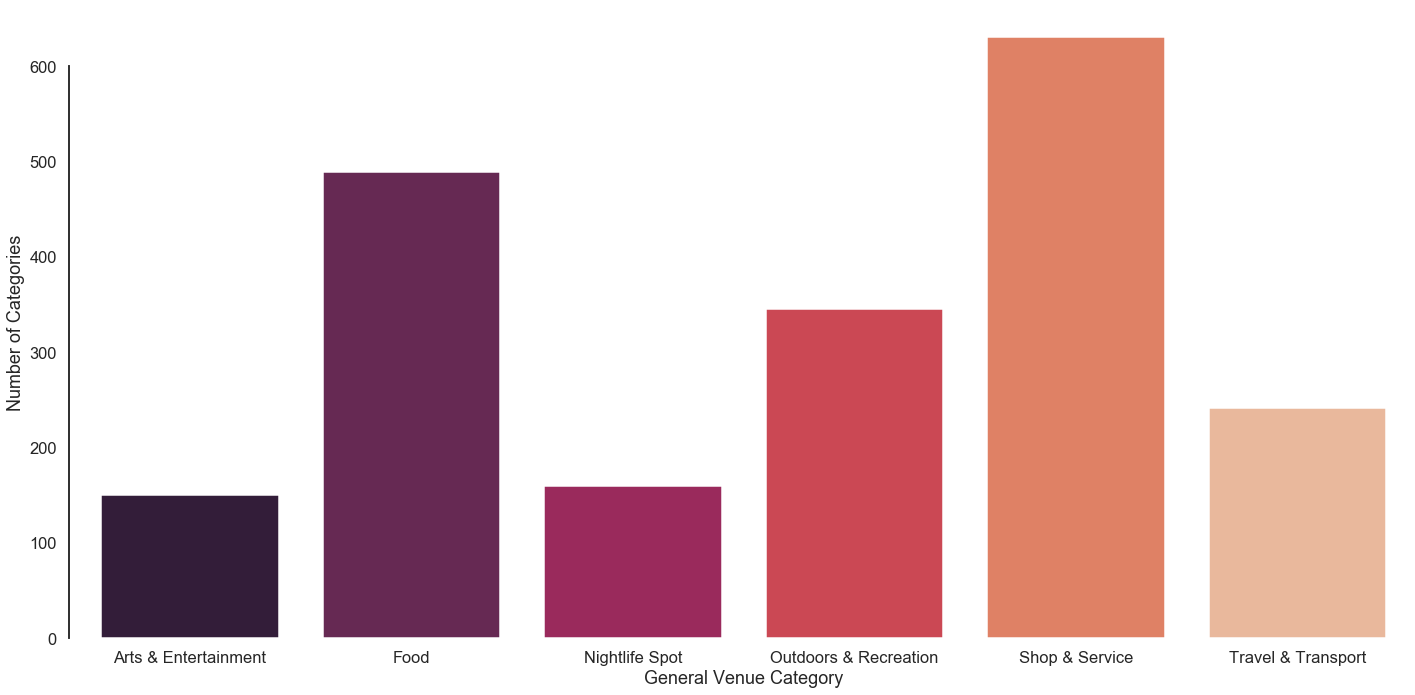

In [36]:
plt.figure(figsize=(20, 10))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=venues_df,
    x=general_ven_cat_df["General Venue Category"],
    y=general_ven_cat_df["Number of Categories"],
)

sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

In [37]:
ven_categoty_crime_df = sf_crime_join_df.copy()

for category in general_venue_category_list:
    ven_categoty_crime_df[category] = np.nan

for i in range(len(general_venue_category_list)):
    for index, row in ven_categoty_crime_df.iterrows():
        ven_categoty_crime_df.loc[index, general_venue_category_list[i]] = venues_df[
            (venues_df["Neighborhood"] == row["Neighborhood"])&
            (venues_df["General Venue Category"] == general_venue_category_list[i])
        ].count()[0]

ven_categoty_crime_df

,Neighborhood,Latitude,Longitude,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
0,Bernal Heights,37.738950,-122.415201,3180,6.0,32.0,38.0,4.0,5.0,4.0
1,The Castro,37.760908,-122.435004,2976,2.0,22.0,34.0,3.0,12.0,15.0
2,Chinatown,37.794138,-122.407791,3654,2.0,17.0,38.0,1.0,1.0,13.0
3,Excelsior,37.724415,-122.427229,3127,12.0,16.0,21.0,3.0,5.0,14.0
4,Financial District,37.794574,-122.399945,9453,7.0,12.0,25.0,4.0,8.0,5.0
5,Financial District,37.794574,-122.399945,9453,7.0,12.0,25.0,4.0,8.0,5.0
6,Glen Park,37.737772,-122.432104,928,23.0,14.0,24.0,3.0,3.0,9.0
7,Hayes Valley,37.775907,-122.424525,5092,10.0,27.0,38.0,12.0,6.0,5.0
8,Ingleside,37.719821,-122.453801,668,10.0,28.0,18.0,2.0,10.0,14.0
9,Ingleside,37.719821,-122.453801,668,10.0,28.0,18.0,2.0,10.0,14.0


### Clustering using KMeans

In [38]:
kclusters = 5
grouped_clustering_df = ven_categoty_crime_df.drop(
    columns=["Neighborhood", "Latitude", "Longitude"]
)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering_df)

In [39]:
sf_merged_df = ven_categoty_crime_df
sf_merged_df.insert(0, 'Cluster_Labels', kmeans.labels_)
sf_merged_df.head() # check the last columns!

,Cluster_Labels,Neighborhood,Latitude,Longitude,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
0,0,Bernal Heights,37.738950,-122.415201,3180,6.0,32.0,38.0,4.0,5.0,4.0
1,0,The Castro,37.760908,-122.435004,2976,2.0,22.0,34.0,3.0,12.0,15.0
2,0,Chinatown,37.794138,-122.407791,3654,2.0,17.0,38.0,1.0,1.0,13.0
3,0,Excelsior,37.724415,-122.427229,3127,12.0,16.0,21.0,3.0,5.0,14.0
4,2,Financial District,37.794574,-122.399945,9453,7.0,12.0,25.0,4.0,8.0,5.0


In [40]:
# create map
map_clusters = folium.Map(location = [sf_latitude, sf_longitude], tiles='Stamen Toner', zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged_df['Latitude'], 
                                  sf_merged_df['Longitude'], 
                                  sf_merged_df['Neighborhood'], 
                                  sf_merged_df['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
       
map_clusters

## Results

### Cluster 1

The first cluster is relatively safe and livable. Mean number of crimes is 2748, it's few compared to the rest. This cluster is great for food and shopping.

In [41]:
cluster_1_df = sf_merged_df.loc[
                                sf_merged_df['Cluster_Labels'] == 0, 
                                sf_merged_df.columns[[1] + list(range(4, sf_merged_df.shape[1]))]
]
cluster_1_df

,Neighborhood,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
0,Bernal Heights,3180,6.0,32.0,38.0,4.0,5.0,4.0
1,The Castro,2976,2.0,22.0,34.0,3.0,12.0,15.0
2,Chinatown,3654,2.0,17.0,38.0,1.0,1.0,13.0
3,Excelsior,3127,12.0,16.0,21.0,3.0,5.0,14.0
10,Inner Sunset,2150,11.0,11.0,17.0,7.0,8.0,11.0
11,Japantown,2100,8.0,33.0,40.0,8.0,7.0,3.0
12,Lakeshore,2327,19.0,10.0,7.0,0.0,5.0,6.0
13,Lone Mountain,2272,6.0,7.0,5.0,4.0,4.0,9.0
19,Outer Mission,2605,4.0,23.0,30.0,4.0,2.0,6.0
20,Pacific Heights,3098,15.0,8.0,19.0,6.0,6.0,10.0


In [42]:
cluster_1_df.mean()

Number of Crimes         2712.857143
Outdoors & Recreation       9.571429
Food                       16.571429
Shop & Service             23.214286
Arts & Entertainment        3.714286
Nightlife Spot              5.571429
Travel & Transport          8.142857
dtype: float64

### Cluster 2

Mean number of crimes in the second cluster is 20 000! This is a record! These are the three most dangerous neighborhoods in all of San Francisco.
However, there are a lot of entertainment, nightlife spots and recreation areas.

In [43]:
cluster_2_df = sf_merged_df.loc[
                                sf_merged_df['Cluster_Labels'] == 1, 
                                sf_merged_df.columns[[1] + list(range(4, sf_merged_df.shape[1]))]
]
cluster_2_df

,Neighborhood,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
14,Mission,22850,14.0,44.0,8.0,6.0,1.0,5.0
25,South of Market,17015,15.0,13.0,17.0,18.0,4.0,13.0
26,Tenderloin,20130,8.0,19.0,15.0,11.0,6.0,10.0


In [44]:
cluster_2_df.mean()

Number of Crimes         19998.333333
Outdoors & Recreation       12.333333
Food                        25.333333
Shop & Service              13.333333
Arts & Entertainment        11.666667
Nightlife Spot               3.666667
Travel & Transport           9.333333
dtype: float64

### Cluster 3

Very average cluster. There are still many crimes (but not as many as in the second cluster) and a lot of shops and foods. And there is nightlife here.

In [45]:
cluster_3_df = sf_merged_df.loc[
                                sf_merged_df['Cluster_Labels'] == 2, 
                                sf_merged_df.columns[[1] + list(range(4, sf_merged_df.shape[1]))]
]
cluster_3_df

,Neighborhood,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
4,Financial District,9453,7.0,12.0,25.0,4.0,8.0,5.0
5,Financial District,9453,7.0,12.0,25.0,4.0,8.0,5.0


In [46]:
cluster_3_df.mean()

Number of Crimes         9453.0
Outdoors & Recreation       7.0
Food                       12.0
Shop & Service             25.0
Arts & Entertainment        4.0
Nightlife Spot              8.0
Travel & Transport          5.0
dtype: float64

### Cluster 4

The safest and best-for-life cluster. There is low crime and many shops, restaurants, and transport.

In [47]:
cluster_4_df = sf_merged_df.loc[
                                sf_merged_df['Cluster_Labels'] == 3, 
                                sf_merged_df.columns[[1] + list(range(4, sf_merged_df.shape[1]))]
]
cluster_4_df

,Neighborhood,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
6,Glen Park,928,23.0,14.0,24.0,3.0,3.0,9.0
8,Ingleside,668,10.0,28.0,18.0,2.0,10.0,14.0
9,Ingleside,668,10.0,28.0,18.0,2.0,10.0,14.0
16,Noe Valley,1702,6.0,16.0,45.0,3.0,3.0,5.0
18,Oceanview,668,16.0,15.0,30.0,0.0,4.0,9.0
23,Presidio Heights,1013,9.0,5.0,22.0,2.0,1.0,0.0
27,Treasure Island,611,26.0,25.0,9.0,13.0,1.0,6.0
28,Twin Peaks,828,22.0,8.0,6.0,4.0,12.0,14.0


In [48]:
cluster_4_df.mean()

Number of Crimes         885.750
Outdoors & Recreation     15.250
Food                      17.375
Shop & Service            21.500
Arts & Entertainment       3.625
Nightlife Spot             5.500
Travel & Transport         8.875
dtype: float64

### Cluster 5

Another average cluster. There is low crime, but still not enough. And here a few interesting places.

In [49]:
cluster_5_df = sf_merged_df.loc[
                                sf_merged_df['Cluster_Labels'] == 4, 
                                sf_merged_df.columns[[1] + list(range(4, sf_merged_df.shape[1]))]
]
cluster_5_df

,Neighborhood,Number of Crimes,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport
7,Hayes Valley,5092,10.0,27.0,38.0,12.0,6.0,5.0
15,Nob Hill,5372,6.0,8.0,16.0,5.0,6.0,11.0
17,North Beach,6501,10.0,11.0,17.0,7.0,6.0,16.0
24,Russian Hill,4582,16.0,8.0,13.0,4.0,11.0,6.0
31,Western Addition,6292,13.0,4.0,3.0,4.0,0.0,0.0


In [50]:
cluster_5_df.mean()

Number of Crimes         5567.8
Outdoors & Recreation      11.0
Food                       11.6
Shop & Service             17.4
Arts & Entertainment        6.4
Nightlife Spot              5.8
Travel & Transport          7.6
dtype: float64

## Discussion

To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).

## Conclusion

The purpose of this project was to find a neighborhood to live or open a business. The venues have been identified using Foursquare API and Geocoding API. Then we group neighborhoods on five different clusters.

My article on __Medium__: [San Francisco Neighborhood Analysis](https://medium.com/@victorysharaf/san-francisco-neighborhood-analysis-2c7849f4c520?source=friends_link&sk=d23d695e36516857983bc9efa3557842)